In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from torch import nn, optim
from PIL import Image
file_dir  = "../input/humpback-whale-identification/train"
df = pd.read_csv("../input/humpback-whale-identification/train.csv")

(array([13496.,  2672.,  1963.,  1674.,  1331.,  1134.,   935.,   863.,
          717.,   576.]),
 array([   0. ,  500.4, 1000.8, 1501.2, 2001.6, 2502. , 3002.4, 3502.8,
        4003.2, 4503.6, 5004. ]),
 <BarContainer object of 10 artists>)

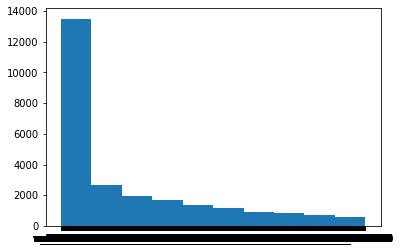

In [2]:
plt.hist(df["Id"])

In [3]:
train = df[df["Id"] != "new_whale"]
train.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
6,000a6daec.jpg,w_dd88965
8,0016b897a.jpg,w_64404ac


(array([3834., 2673., 1960., 1677., 1329., 1133.,  938.,  860.,  717.,
         576.]),
 array([   0. ,  500.3, 1000.6, 1500.9, 2001.2, 2501.5, 3001.8, 3502.1,
        4002.4, 4502.7, 5003. ]),
 <BarContainer object of 10 artists>)

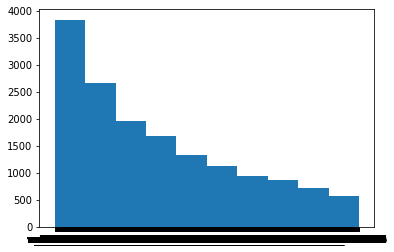

In [4]:
plt.hist(train["Id"])

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def get_encoder(x):
    values = np.array(x)
    le = LabelEncoder()
    int_label =le.fit_transform(values)    
    ohe = OneHotEncoder(sparse =False)
    int_label = int_label.reshape(len(int_label),1)
    ohe.fit(int_label)
    return le,ohe

le, ohe = get_encoder(train["Id"])

def prepare_label(x,le,ohe):
    values = np.array(x)   
    int_label = le.transform(values)
    
    int_label = int_label.reshape(len(int_label),1)
    onehot_label = ohe.transform(int_label)
    
    y = onehot_label
    return y

from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2)

train_labels = prepare_label(train["Id"],le,ohe)
val_labels = prepare_label(val["Id"],le,ohe)

In [5]:
class WhaleDataset(Dataset):
    def __init__(self, df, file_dir, labels = None, mode = "train", transform = None):
        self.df = df
        self.file_dir = file_dir
        self.labels = labels
        self.mode = mode
        self.transform = transform
        
    def __getitem__(self, index):
        image_name = self.df["Image"].iloc[index]
        label = self.labels[index]
        
        image = Image.open(os.path.join(self.file_dir,image_name))
        image = image.resize((384,384))        
        image = image.convert("RGB")
        
        if self.transform != None:
            image = self.transform(image)
        if self.mode == "train" or self.mode == "val":
            return image, label
        else:
            return image
    
    def __len__(self):
        return self.df.shape[0]

In [6]:
flip_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=1), 
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
simple_transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

pretrain_data = WhaleDataset(train[:500], file_dir, labels = train_labels[:500], transform =simple_transform)
train_data = WhaleDataset(train, file_dir, labels = train_labels, transform =simple_transform)
new_data = WhaleDataset(train, file_dir, labels = train_labels, transform =flip_transform)
val_data = WhaleDataset(val, file_dir, labels = val_labels, transform =simple_transform)
train_data = torch.utils.data.ConcatDataset([train_data, new_data])

pretrain_loader = DataLoader(pretrain_data, batch_size = 32, shuffle=True)
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True)
val_loader = DataLoader(val_data, batch_size = 32, shuffle=True)

In [7]:
train_loader = torch.load("../input/humpackwhalemodel/train_loader.pt")
val_loader = torch.load("../input/humpackwhalemodel/val_loader.pt")

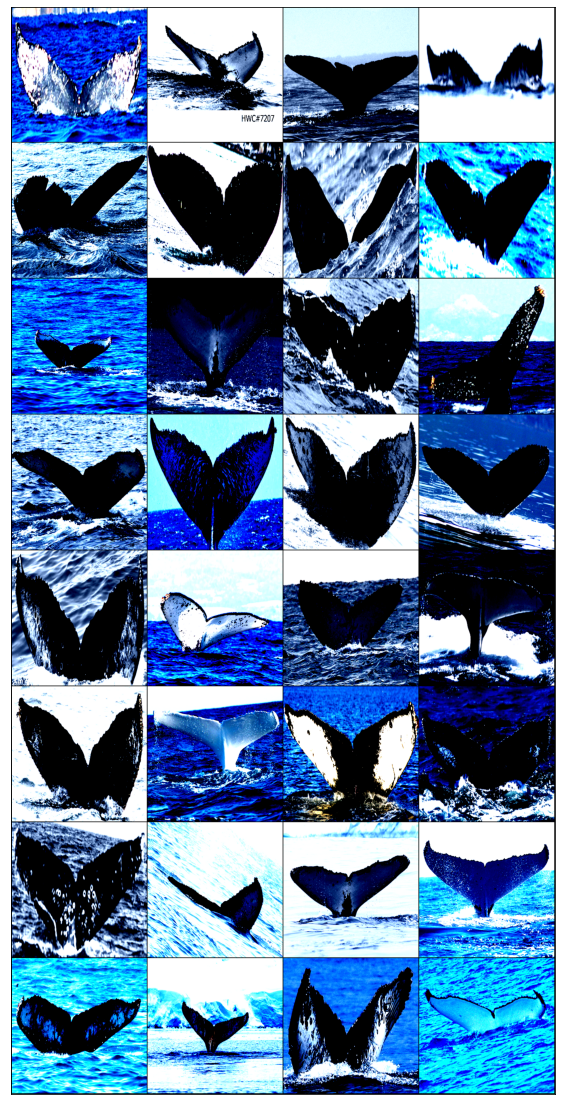

In [8]:
for images, labels in train_loader:
    
    fig, ax = plt.subplots(figsize = (20, 20))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(images, nrow=4).permute(1,2,0))
    break

In [9]:
class BasicBlock(nn.Module):
    def __init__(self, input_size, output_size, stride = 1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(input_size, output_size, kernel_size = 3,padding = 1, stride = stride)
        self.bn1 = nn.BatchNorm2d(output_size)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(output_size, output_size, kernel_size = 3,padding = 1, stride = 1)
        self.bn2 = nn.BatchNorm2d(output_size)
        self.stride = stride
        self.downsample = downsample
        
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out = out + identity
        out = self.relu(out)
        
        return out

In [10]:
class ResNet(nn.Module):
    def __init__(self,block,layers):
        super().__init__()
        self.inplanes = 64
        self.layer0 = nn.Sequential(nn.Conv2d(3,self.inplanes, kernel_size = 7, stride = 2, padding = 3),
                                   nn.BatchNorm2d(self.inplanes),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))

        self.layer1 = self._make_layer(block,64,layers[0])
        self.layer2 = self._make_layer(block,128,layers[1],stride=2)
        self.layer3 = self._make_layer(block,256,layers[2],stride=2)
        self.layer4 = self._make_layer(block,512,layers[3],stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(nn.Dropout(p=0.5),
                                nn.Linear(512,5004))
        
    def _make_layer(self, block, planes, blocks, stride = 1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(nn.Conv2d(self.inplanes, planes, kernel_size = 1, stride = stride),
                                      nn.BatchNorm2d(planes))
            
        layers = []
        
        layers.append(block(self.inplanes, planes, stride, downsample = downsample))
        self.inplanes = planes
        for _ in range(1,blocks):
            layers.append(block(self.inplanes, planes))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.layer0(x)
                                            
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
                                            
        out = self.avgpool(out)
        out = torch.flatten(out,1) 
        out = self.fc(out)
                                            
        return out
     

def resnet34():
    layers=[3, 4, 6, 3]
    model = ResNet(BasicBlock, layers=layers)
    return model

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


model = resnet34()
model = model.to(device)
model

In [12]:
model = torch.load("../input/humpackwhalemodel/HumpbackWhale6.h5")

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay= 1e-5)

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 10
for epoch in range(num_epochs):

    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(pretrain_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Train_Acc: %.2f]" \
              %(epoch+1, num_epochs, train_losses[-1], train_accuracy))     

In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay= 1e-6)

In [14]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 2
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))
    

100%|██████████| 99/99 [01:45<00:00,  1.06s/it]


[Epoch: 1 / 2], [Trian loss: 0.000894], [Val loss: 0.001139], [Train_Acc: 47.07], [Val_Acc: 37.68]


100%|██████████| 99/99 [01:15<00:00,  1.31it/s]

[Epoch: 2 / 2], [Trian loss: 0.000894], [Val loss: 0.001129], [Train_Acc: 47.30], [Val_Acc: 37.93]


In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay= 1e-7)

In [16]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 2
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

100%|██████████| 99/99 [01:15<00:00,  1.31it/s]


[Epoch: 1 / 2], [Trian loss: 0.000896], [Val loss: 0.001130], [Train_Acc: 47.18], [Val_Acc: 37.52]


100%|██████████| 99/99 [01:15<00:00,  1.31it/s]

[Epoch: 2 / 2], [Trian loss: 0.000887], [Val loss: 0.001143], [Train_Acc: 47.27], [Val_Acc: 37.68]


In [17]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 3
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

100%|██████████| 99/99 [01:15<00:00,  1.31it/s]


[Epoch: 1 / 3], [Trian loss: 0.000880], [Val loss: 0.001143], [Train_Acc: 47.29], [Val_Acc: 37.74]


100%|██████████| 99/99 [01:15<00:00,  1.32it/s]


[Epoch: 2 / 3], [Trian loss: 0.000873], [Val loss: 0.001136], [Train_Acc: 47.54], [Val_Acc: 37.68]


100%|██████████| 99/99 [01:15<00:00,  1.31it/s]

[Epoch: 3 / 3], [Trian loss: 0.000866], [Val loss: 0.001135], [Train_Acc: 47.65], [Val_Acc: 37.93]


optimizer = torch.optim.Adam(model.parameters(), lr=8e-7, weight_decay= 1e-6)

In [18]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 5
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

100%|██████████| 99/99 [01:15<00:00,  1.31it/s]


[Epoch: 1 / 5], [Trian loss: 0.000860], [Val loss: 0.001136], [Train_Acc: 47.98], [Val_Acc: 37.96]


100%|██████████| 99/99 [01:16<00:00,  1.30it/s]


[Epoch: 2 / 5], [Trian loss: 0.000854], [Val loss: 0.001134], [Train_Acc: 48.16], [Val_Acc: 38.15]


100%|██████████| 99/99 [01:15<00:00,  1.31it/s]


[Epoch: 3 / 5], [Trian loss: 0.000848], [Val loss: 0.001139], [Train_Acc: 48.20], [Val_Acc: 37.77]


100%|██████████| 99/99 [01:15<00:00,  1.32it/s]


[Epoch: 4 / 5], [Trian loss: 0.000843], [Val loss: 0.001146], [Train_Acc: 48.40], [Val_Acc: 37.96]


100%|██████████| 99/99 [01:15<00:00,  1.30it/s]

[Epoch: 5 / 5], [Trian loss: 0.000837], [Val loss: 0.001142], [Train_Acc: 48.48], [Val_Acc: 38.25]


In [19]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 5
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

100%|██████████| 99/99 [01:15<00:00,  1.31it/s]


[Epoch: 1 / 5], [Trian loss: 0.000832], [Val loss: 0.001135], [Train_Acc: 48.74], [Val_Acc: 38.09]


100%|██████████| 99/99 [01:16<00:00,  1.30it/s]


[Epoch: 2 / 5], [Trian loss: 0.000827], [Val loss: 0.001141], [Train_Acc: 48.73], [Val_Acc: 38.22]


100%|██████████| 99/99 [01:16<00:00,  1.30it/s]


[Epoch: 3 / 5], [Trian loss: 0.000822], [Val loss: 0.001133], [Train_Acc: 49.02], [Val_Acc: 38.18]


100%|██████████| 99/99 [01:16<00:00,  1.30it/s]


[Epoch: 4 / 5], [Trian loss: 0.000817], [Val loss: 0.001136], [Train_Acc: 49.16], [Val_Acc: 38.22]


100%|██████████| 99/99 [01:15<00:00,  1.31it/s]

[Epoch: 5 / 5], [Trian loss: 0.000812], [Val loss: 0.001137], [Train_Acc: 49.41], [Val_Acc: 37.99]


optimizer = torch.optim.Adam(model.parameters(), lr=2.5e-6, weight_decay= 1e-6)

In [20]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 5
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

100%|██████████| 99/99 [01:15<00:00,  1.31it/s]


[Epoch: 1 / 5], [Trian loss: 0.000808], [Val loss: 0.001134], [Train_Acc: 49.59], [Val_Acc: 38.06]


100%|██████████| 99/99 [01:15<00:00,  1.30it/s]


[Epoch: 2 / 5], [Trian loss: 0.000804], [Val loss: 0.001135], [Train_Acc: 49.80], [Val_Acc: 38.38]


100%|██████████| 99/99 [01:15<00:00,  1.31it/s]


[Epoch: 3 / 5], [Trian loss: 0.000799], [Val loss: 0.001145], [Train_Acc: 49.69], [Val_Acc: 38.12]


100%|██████████| 99/99 [01:15<00:00,  1.31it/s]


[Epoch: 4 / 5], [Trian loss: 0.000795], [Val loss: 0.001130], [Train_Acc: 50.07], [Val_Acc: 38.25]


100%|██████████| 99/99 [01:15<00:00,  1.31it/s]

[Epoch: 5 / 5], [Trian loss: 0.000791], [Val loss: 0.001135], [Train_Acc: 50.13], [Val_Acc: 38.38]


In [21]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 5
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

100%|██████████| 99/99 [01:15<00:00,  1.31it/s]


[Epoch: 1 / 5], [Trian loss: 0.000787], [Val loss: 0.001136], [Train_Acc: 50.32], [Val_Acc: 38.47]


100%|██████████| 99/99 [01:15<00:00,  1.31it/s]


[Epoch: 2 / 5], [Trian loss: 0.000783], [Val loss: 0.001125], [Train_Acc: 50.51], [Val_Acc: 38.73]


100%|██████████| 99/99 [01:15<00:00,  1.30it/s]


[Epoch: 3 / 5], [Trian loss: 0.000779], [Val loss: 0.001130], [Train_Acc: 50.61], [Val_Acc: 38.15]


100%|██████████| 99/99 [01:15<00:00,  1.31it/s]


[Epoch: 4 / 5], [Trian loss: 0.000775], [Val loss: 0.001129], [Train_Acc: 50.65], [Val_Acc: 38.69]


100%|██████████| 99/99 [01:15<00:00,  1.31it/s]

[Epoch: 5 / 5], [Trian loss: 0.000771], [Val loss: 0.001123], [Train_Acc: 50.92], [Val_Acc: 38.98]


In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-6, weight_decay= 1e-7)

In [ ]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 1
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

  3%|▎         | 21/785 [00:19<12:18,  1.03it/s]

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 3
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 3
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

optimizer = torch.optim.Adam(model.parameters(), lr=6.25e-7, weight_decay= 1e-6)

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 3
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

optimizer = torch.optim.Adam(model.parameters(), lr=5e-6, weight_decay= 1e-6)

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 1
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

optimizer = torch.optim.Adam(model.parameters(), lr=2e-6, weight_decay= 1e-6)

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 1
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 3
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 3
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

optimizer = torch.optim.Adam(model.parameters(), lr=3e-7, weight_decay= 1e-6)

In [22]:
torch.save(train_loader, 'train_loader.pt')
torch.save(val_loader, 'val_loader.pt')
torch.save(model, "HumpbackWhale7.h5")

model = torch.load("../input/humpackwhalemodel/HumpbackWhale2.h5")

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay= 1e-5)

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 1
for epoch in range(num_epochs):
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Val loss: %.6f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, val_losses[-1], val_accuracy))

new_whale_df = df[df["Id"] == "new_whale"]
_, val_new_whale = train_test_split(new_whale_df, test_size=0.4)
val = pd.concat((val_new_whale, val), axis = 0)

model.eval()
pred = None
for i in range(val.shape[0]):
    with torch.no_grad():
        image_name = val["Image"].iloc[i]
        image = Image.open(os.path.join(file_dir,image_name))
        image = image.resize((384,384))
        image = image.convert("RGB")
        image = val_data.transform(image)
        image = image.to(device)
        if pred is None:
            pred = model(image.unsqueeze(0)).cpu().detach().numpy()
        else:
            pred = np.concatenate((pred, model(image.unsqueeze(0)).cpu().detach().numpy()),axis = 0)
pred = np.concatenate((np.zeros((pred.shape[0],1)), pred),axis = 1)
pred

label_set = ['new_whale']+list(le.classes_)

def map5(X, y, label_set):
    score = 0
    for i in range(X.shape[0]):
        pred = X[i].argsort()[-5:][::-1]
        for j in range(pred.shape[0]):
            if label_set[pred[j]] == y[i]:
                score += (5 - j)/5
                break
                
    return float(score/X.shape[0])

best_th = 0
best_score = 0
y = np.array(val["Id"])
for th in np.arange(-0.5, 0.5, 0.01):
    pred[:,0] = th
    score = map5(pred, y, label_set)
    if score > best_score:
        best_score = score
        best_th = th
    print("Threshold = {:.3f}, MAP5 = {:.3f}".format(th,score))

print("Best Threshold = {:.3f}, Best MAP5 = {:.3f}".format(best_th,best_score))